### Yelp capstone project part 4: 
KMeans divide review text into 5 clusters; cluster centroids reveal top features in each cluster; perform PCA to reduce dimensionality and speed up Logistic regression and Random forest classifier.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.style.use("ggplot")

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/Users/fanyang/Documents/yelp_project/12_24/last_2_years_restaurant_reviews_AZ.csv')

In [3]:
df.head(3)

,business_id,Unnamed: 0,name,categories,starts_business,cool,date,funny,review_id,stars,text,useful,user_id
0,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2017-06-26,0,VpdB20xoSH514ks0MkNqGQ,1,False advertisement! Website says open until 1...,0,GbYhdXKQGYGp6D2_S3Oyfw
1,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,1,2017-01-29,0,Xvdqblf2f7nx2h4B2UuD-g,2,Came in so my kiddo could skate and I could ju...,0,CU_RU1o3sKSwymRotn3DUg
2,-01XupAWZEXbdNbxNg5mEg,8836,18 Degrees Neighborhood Grill,"Nightlife, Bars, Restaurants, American (Tradit...",3.0,0,2016-09-03,1,Z7ufB8dFZ_9VjkcntOEsig,1,Horrible! Had the happy hour nachos. The che...,2,-XoCb6sUMa7NoFayUW0FlA


#### select review text as documents

In [4]:
documents = df['text']
indx = pd.notnull(documents)
documents = documents[indx]
documents = documents.values
documents[:5]

array(['False advertisement! Website says open until 11pm and the truth is...they are only open until the ice is open.',
       "Came in so my kiddo could skate and I could just watch front the comfort of the bar.  Service was non existent.  The waitresses walked past me about 10 times.... never even making eye contact.  I had to go to the bar to get a drink twice.  The bartender was speedy and friendly!  It's annoying and frustrating to be ignored.  Tips are earned.",
       'Horrible!  Had the happy hour nachos.  The cheese tasted like old plastic and smelled like vomit!  Absolutely disgusting!    I would never eat here again!',
       'Been here a few times and most times decent to good service.\n\nLast time I was there I had the best burger I have had in a long time. Great flavor!\n\nGood bar atmosphere and really nice to walk hockey or LaCrosse at the same time.',
       "This place sucks. The waitress is really rude and wont give you water unless you eat food. My friend and i wen

#### take review is positive when stars given by reviewer above 4.0

In [5]:
df['positive_review'] = (df['stars']>4)
df['positive_review'].value_counts(normalize=True)

False    0.514724
True     0.485276
Name: positive_review, dtype: float64

In [6]:
target = df['positive_review'].values
target = target[indx]
target[:10]

array([False, False, False, False, False, False, False, False, False,
       False])

In [7]:
indices = df.index

In [8]:
documents.size, target.size

(462965, 462965)

#### split training and test datasets

In [9]:
from sklearn.cross_validation import train_test_split

/usr/local/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
documents_train, documents_test, target_train, target_test, indices_train, indices_test = train_test_split(documents,target,indices,test_size=0.2, random_state=0)

#### tranform review text into tf-idf by TfidfVectorizer 

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,min_df=1)

X_train = vectorizer.fit_transform(documents_train).toarray()

features_name = vectorizer.get_feature_names()

X_test = vectorizer.transform(documents_test).toarray()

X_all = vectorizer.transform(documents).toarray()

#### Cluster review text with KMeans

In [12]:
# choose 5 clusters

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5,random_state=42)
kmeans.fit(X_train)
assigned_cluster_train = kmeans.predict(X_train)
assigned_cluster_test = kmeans.predict(X_test)

In [13]:
assigned_cluster_all = kmeans.predict(X_all)

In [14]:
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
print("top features for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features_name[i] for i in centroid)))

top features for each cluster:
0: chicken, good, food, fried, place, rice, ordered, salad, great, like
1: order, food, time, minutes, service, just, came, asked, got, didn
2: good, food, place, best, delicious, service, love, like, amazing, really
3: pizza, crust, good, great, place, wings, service, best, cheese, love
4: great, food, service, place, good, friendly, love, atmosphere, amazing, staff


In [12]:
# choose 2 clusters

from sklearn.cluster import KMeans
kmeans2 = KMeans(n_clusters=2,random_state=42)
kmeans2.fit(X_train)
assigned_cluster_train2 = kmeans2.predict(X_train)
assigned_cluster_test2 = kmeans2.predict(X_test)

assigned_cluster_all2 = kmeans2.predict(X_all)

top_centroids = kmeans2.cluster_centers_.argsort()[:,-1:-11:-1]
print("top features for each cluster:")
for num, centroid in enumerate(top_centroids):
    print("%d: %s" % (num, ", ".join(features_name[i] for i in centroid)))

top features for each cluster:
0: good, food, place, just, like, time, order, ordered, service, chicken
1: great, food, place, service, love, amazing, friendly, good, staff, delicious


#### Print out the rating and review of a random sample from each cluster

In [15]:
for i in range(kmeans.n_clusters):
    cluster = indices[assigned_cluster_all==i]
    sample_reviews = np.random.choice(cluster, 3, replace=False)
    print("cluster %d:" % i)
    for review in sample_reviews:
        print("rating: %f" % df.loc[review]['stars'])
        print("       %s" % df.loc[review]['text'])

cluster 0:
rating: 5.000000
       Highly recommend this hippie coffee house .... The food and coffee is amazing ... Started off with a homemade donut filled with Nutella .... A M A Z I N G!!
Then had a grilled cheese sandwich with chicken flavored with chorizo .... With roasted potatoes .... Grilled and seasoned perfectly ..... If you are a red state voter you may not care for the clientele and stickers ...
rating: 5.000000
       Good Lord!!! Good greasy, grandma tasting, filling, soul food. Seriously good. The items are made daily so it's likely your favorite dish maybe be sold out by time evening comes. 

My significant other and I had Mrs. Whites Monday night. He was craving something filling and filling, I wanted Mac and cheese. 

On a Monday there were about 5 couples dining, including us. I ordered smothered chicken with Mac and cheese and green beans win potatoes. It came with 3 huge pieces of chicken. He ordered ox tails, sweet potatoes, and rice and gravy. Both dishes came w

#### PCA reduce dimensionality

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.fit_transform(X_test)

In [17]:
# PCA transform train and test dataset
from sklearn.decomposition import PCA

n_col = 50

pca = PCA(n_components = n_col)

train_components = pca.fit_transform(X_scaled_train)
test_components = pca.transform(X_scaled_test)

In [18]:
print(train_components.shape)
print(test_components.shape)

(370372, 50)
(92593, 50)


In [19]:
print(pca.components_.shape)

(50, 1000)


#### visualize percentage of variance the principal components explain

In [20]:
print(pca.explained_variance_ratio_.shape)
print(pca.explained_variance_ratio_)

(50,)
[0.00580321 0.00403528 0.00320956 0.00272446 0.00268695 0.00257096
 0.00242632 0.00236801 0.00228042 0.00217698 0.00211921 0.00209025
 0.00198988 0.00196692 0.00191002 0.00188302 0.00183782 0.00182325
 0.00180191 0.00177712 0.0017437  0.00172747 0.0016967  0.00164593
 0.00163346 0.00161987 0.00160746 0.00158986 0.00156805 0.00156665
 0.00154086 0.00152642 0.00151952 0.00150559 0.00148266 0.00147766
 0.00146742 0.00145837 0.0014456  0.00143103 0.00142686 0.00140653
 0.00140005 0.0013805  0.0013719  0.00136875 0.00135182 0.00133726
 0.00132183 0.00130716]


Text(0,0.5,'Proportion of Variance Explained')

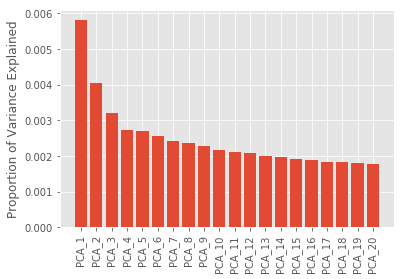

In [21]:
pca_range = np.arange(20) + 1
explained_var_top20 = pca.explained_variance_ratio_[:20]

pca_names = ['PCA_%s' % i for i in pca_range]

plt.bar(pca_range, explained_var_top20, align='center')

xticks = plt.xticks(pca_range, pca_names, rotation=90)

plt.ylabel('Proportion of Variance Explained')

#### test if PCA affect performance of positive/negative classifier 

In [22]:
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score,roc_auc_score

In [23]:
def get_performance_metrics(y_train, y_train_pred, y_test, y_test_pred, threshold=0.5):
    metric_names = ['AUC','Accuracy','Precision','Recall','f1-score']
    metric_values_train = [roc_auc_score(y_train, y_train_pred),
                    accuracy_score(y_train, y_train_pred>threshold),
                    precision_score(y_train, y_train_pred>threshold),
                    recall_score(y_train, y_train_pred>threshold),
                    f1_score(y_train, y_train_pred>threshold)
                   ]
    metric_values_test = [roc_auc_score(y_test, y_test_pred),
                    accuracy_score(y_test, y_test_pred>threshold),
                    precision_score(y_test, y_test_pred>threshold),
                    recall_score(y_test, y_test_pred>threshold),
                    f1_score(y_test, y_test_pred>threshold)
                   ]
    all_metrics = pd.DataFrame({'metrics':metric_names,
                                'train':metric_values_train,
                                'test':metric_values_test},columns=['metrics','train','test']).set_index('metrics')
    print(all_metrics)

In [24]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [25]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    
    clf.fit(X_train, y_train)

    y_train_pred = clf.predict(X_train)
    p_train_pred = clf.predict_proba(X_train)[:,1]

    y_test_pred = clf.predict(X_test)
    p_test_pred = clf.predict_proba(X_test)[:,1]

    get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred)
    plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred)

#### Logistic regression classifier

In [26]:
%%time
from sklearn.linear_model import LogisticRegression

clf_lrc = LogisticRegression()
clf_lrc.fit(X_scaled_train, target_train)

CPU times: user 2min 25s, sys: 10min 13s, total: 12min 38s
Wall time: 17min 7s


              train      test
metrics                      
AUC        0.908139  0.908985
Accuracy   0.830109  0.829620
Precision  0.813094  0.810943
Recall     0.844134  0.845198
f1-score   0.828324  0.827717


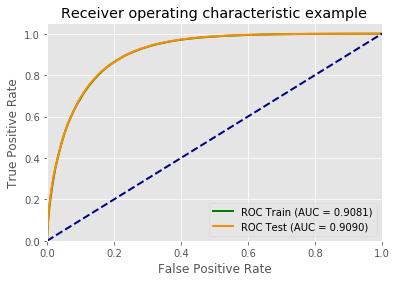

CPU times: user 2min 30s, sys: 10min 19s, total: 12min 50s
Wall time: 17min 33s


In [27]:
%%time
train_test_model(clf_lrc, X_scaled_train, target_train, X_scaled_test, target_test)

#### PCA + Logistic regression classifier

In [28]:
%%time
from sklearn.linear_model import LogisticRegression
clf_lrc_pca = LogisticRegression()
clf_lrc_pca.fit(X_scaled_train, target_train)

CPU times: user 3min 19s, sys: 16min 54s, total: 20min 14s
Wall time: 38min 29s


              train      test
metrics                      
AUC        0.889618  0.892533
Accuracy   0.809637  0.813366
Precision  0.792867  0.795454
Recall     0.822914  0.827334
f1-score   0.807611  0.811081


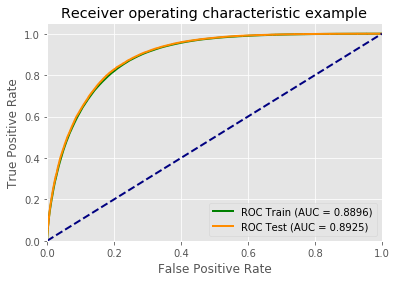

CPU times: user 4.66 s, sys: 944 ms, total: 5.6 s
Wall time: 4.73 s


In [29]:
%%time
train_test_model(clf_lrc_pca, train_components, target_train, test_components, target_test)

####  plot logistic regression coefficients against principal components


In [30]:
clf_lrc_pca.coef_[0]

array([-0.67719228, -0.26536063,  0.24199084, -0.20752108, -0.15413744,
       -0.00421759,  0.49993045,  0.50077585, -0.30435058,  0.11445072,
        0.15115873,  0.01490535, -0.15824154,  0.10459768,  0.05031249,
        0.08038916, -0.1603892 , -0.1737188 ,  0.03489049,  0.06037193,
        0.20743334, -0.12779637,  0.09840969,  0.02168535,  0.12022529,
        0.00323019,  0.02250845, -0.06953855, -0.00934263,  0.02933235,
       -0.07502245,  0.03190693, -0.05040016,  0.0047986 , -0.06241581,
       -0.01854341, -0.00572528,  0.0442797 , -0.09174595, -0.02436941,
       -0.03988774,  0.0811435 ,  0.08598168,  0.03538487,  0.00485761,
       -0.00620223, -0.04151824, -0.01225572,  0.01154579,  0.02369731])

Text(0,0.5,'Coefficients')

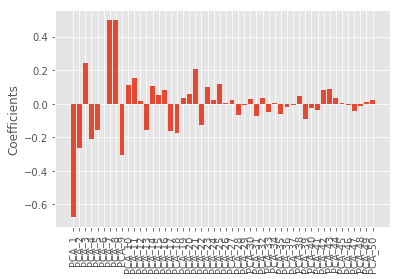

In [31]:
pca_range = np.arange(50) + 1

pca_names = ['PCA_%s' % i for i in pca_range]

plt.bar(pca_range, clf_lrc_pca.coef_[0], align='center')

xticks = plt.xticks(pca_range, pca_names, rotation=90)

plt.ylabel('Coefficients')

#### random forest classifier

In [32]:
%%time
from sklearn.ensemble import RandomForestClassifier


clf_rfc = RandomForestClassifier(max_depth=20, n_estimators=10, min_samples_leaf=100)

clf_rfc.fit(X_scaled_train, target_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


CPU times: user 41.8 s, sys: 5.92 s, total: 47.7 s
Wall time: 53.3 s


              train      test
metrics                      
AUC        0.860609  0.859348
Accuracy   0.780855  0.779940
Precision  0.771800  0.770191
Recall     0.778972  0.777577
f1-score   0.775370  0.773866


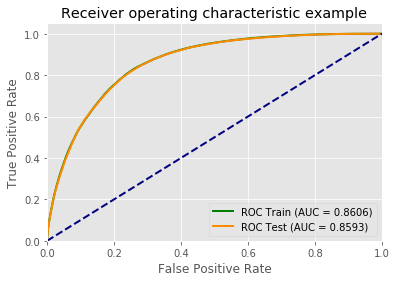

CPU times: user 46.3 s, sys: 4.33 s, total: 50.6 s
Wall time: 52 s


In [33]:
%%time
train_test_model(clf_rfc, X_scaled_train, target_train, X_scaled_test, target_test)

#### PCA + Random forest classifier

In [34]:
%%time
from sklearn.ensemble import RandomForestClassifier

clf_rfc_pca = RandomForestClassifier(max_depth=20, n_estimators=10, min_samples_leaf=100)

clf_rfc_pca.fit(train_components, target_train)

CPU times: user 25.4 s, sys: 300 ms, total: 25.7 s
Wall time: 25.9 s


              train      test
metrics                      
AUC        0.890883  0.872665
Accuracy   0.807067  0.790384
Precision  0.790503  0.772312
Recall     0.819933  0.804229
f1-score   0.804949  0.787947


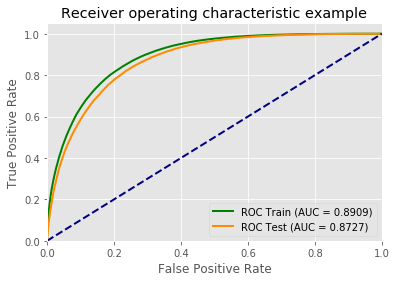

CPU times: user 29.3 s, sys: 625 ms, total: 29.9 s
Wall time: 30 s


In [35]:
%%time
train_test_model(clf_rfc_pca, train_components, target_train, test_components, target_test)

#### plot RF feature importances against principal components


In [36]:
clf_rfc_pca.feature_importances_

array([0.38449677, 0.06326542, 0.05611305, 0.04915699, 0.02558869,
       0.0079779 , 0.09434483, 0.09121528, 0.04752125, 0.00970022,
       0.01045324, 0.00517542, 0.01093878, 0.00418865, 0.00539091,
       0.01682514, 0.01027739, 0.01142697, 0.00266425, 0.00349277,
       0.00859314, 0.00619366, 0.0028019 , 0.00333958, 0.00508532,
       0.00342012, 0.00306482, 0.00387848, 0.00327411, 0.00290979,
       0.00288543, 0.00422061, 0.00335944, 0.00248681, 0.00268514,
       0.00168681, 0.00120698, 0.00186319, 0.00391034, 0.0024195 ,
       0.0017374 , 0.00317927, 0.00247237, 0.00172927, 0.00130334,
       0.00263751, 0.0020514 , 0.001356  , 0.00138138, 0.00265299])

Text(0,0.5,'feature importance')

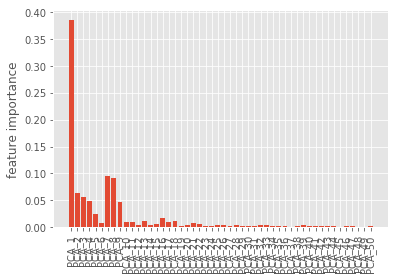

In [37]:
pca_range = np.arange(50) + 1

pca_names = ['PCA_%s' % i for i in pca_range]

plt.bar(pca_range, clf_rfc_pca.feature_importances_, align='center')

xticks = plt.xticks(pca_range, pca_names, rotation=90)

plt.ylabel('feature importance')